In [3]:
import sys
import os

# Add the project ROOT directory to Python path
root_path = os.path.abspath("..")
sys.path.append(root_path)

print(root_path)

c:\Users\roger


In [4]:
from mne.datasets import eegbci
import mne

In [ ]:
runs = [6, 10]
data_path = eegbci.load_data(1, runs, path="../data/physionet")

data_path

In [ ]:

import urllib.request, time, sys
url = "https://physionet.org/files/eegmmidb/1.0.0/S002/S002R06.edf"
t0 = time.time()
try:
    urllib.request.urlretrieve(url, "test_S002R06.edf")
    print("Downloaded in", time.time()-t0, "s")
except Exception as e:
    print("Error:", e)
    sys.exit(1)


In [7]:
data_path

[WindowsPath('../data/physionet/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf'),
 WindowsPath('../data/physionet/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf')]

In [8]:
import mne

raw_list = [mne.io.read_raw_edf(f, preload=True) for f in data_path]
raw = mne.concatenate_raws(raw_list)

raw

Extracting EDF parameters from ..\data\physionet\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R06.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from ..\data\physionet\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R10.edf...
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


<RawEDF | S001R06.edf, 64 x 40000 (250.0 s), ~19.6 MiB, data loaded>

In [9]:
events, event_id = mne.events_from_annotations(raw)
events[:10], event_id

Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]


(array([[   0,    0,    1],
        [ 672,    0,    3],
        [1328,    0,    1],
        [2000,    0,    2],
        [2656,    0,    1],
        [3328,    0,    2],
        [3984,    0,    1],
        [4656,    0,    3],
        [5312,    0,    1],
        [5984,    0,    2]]),
 {np.str_('T0'): 1, np.str_('T1'): 2, np.str_('T2'): 3})

In [10]:
epochs = mne.Epochs(
    raw,
    events=events,
    event_id=event_id,
    tmin=0.5,   # start 0.5 sec after cue
    tmax=4.0,   # end at 4 sec
    baseline=None,
    preload=True
)

epochs

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 561 original time points ...
0 bad epochs dropped


<Epochs | 60 events (all good), 0.5 – 4 s (baseline off), ~16.5 MiB, data loaded,
 np.str_('T0'): 30
 np.str_('T1'): 14
 np.str_('T2'): 16>

In [11]:
X = epochs.get_data()       # shape: (n_epochs, n_channels, n_times)
y = epochs.events[:, -1]    # integer labels

X.shape, y.shape, y[:10]

((60, 64, 561), (60,), array([1, 3, 1, 2, 1, 2, 1, 3, 1, 2]))

In [12]:
import numpy as np

mask = (y == event_id['T1']) | (y == event_id['T2'])
X = X[mask]
y = y[mask]

X.shape, y.shape, y[:10]

((30, 64, 561), (30,), array([3, 2, 2, 3, 2, 3, 3, 2, 2, 3]))

In [13]:
y_clean = np.where(y == event_id['T1'], 0, 1)

y_clean[:10]

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 1])

In [14]:
epochs_filtered = epochs.copy().filter(8., 30., fir_design='firwin')
X_filt = epochs_filtered.get_data()

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)



In [15]:
X_f = X_filt[mask]       # only T1 / T2 trials
y_f = y_clean            # already binary cleaned

In [16]:
X_f.shape, y_f.shape

((30, 64, 561), (30,))

In [17]:
# Standardize each channel across time
X_std = (X_f - X_f.mean(axis=-1, keepdims=True)) / X_f.std(axis=-1, keepdims=True)

In [20]:
from src.preprocessing import bandpass_filter, standardize_epochs

# Step 1: Filter the epochs
epochs_filtered = bandpass_filter(epochs)

# Step 2: Extract filtered data
X_filt = epochs_filtered.get_data()

# Step 3: Keep only T1/T2 trials
X_f = X_filt[mask]   # mask you already created earlier

# Step 4: Standardize
X_std = standardize_epochs(X_f)

# Step 5: Print results
print("Filtered shape:", X_f.shape)
print("Standardized shape:", X_std.shape)
print("Labels:", y_f[:10])

Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

Filtered shape: (30, 64, 561)
Standardized shape: (30, 64, 561)
Labels: [1 0 0 1 0 1 1 0 0 1]


In [1]:
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y_f, test_size=0.3, random_state=42, stratify=y_f
)

In [2]:
csp = CSP(n_components=6, reg=None, log=True)
lda = LinearDiscriminantAnalysis()

clf = Pipeline([
    ('csp', csp),
    ('lda', lda)
])

In [24]:
clf.fit(X_train, y_train)

Computing rank from data with rank=None
    Using tolerance 9.9 (2.2e-16 eps * 64 dim * 7e+14  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


,steps,"[('csp', ...), ('lda', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,6
,reg,None
,log,True
,cov_est,'concat'
,transform_into,'average_power'
,norm_trace,False
,cov_method_params,None


In [25]:
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("CSP + LDA Accuracy:", acc)
print("Predictions:", y_pred)
print("Actual:", y_test)

CSP + LDA Accuracy: 1.0
Predictions: [0 1 1 1 0 1 1 0 0]
Actual: [0 1 1 1 0 1 1 0 0]


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [27]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [28]:
train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=8, shuffle=False)

In [29]:
class SimpleEEGNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, (1, 10), padding=(0, 5))
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, (64, 1))
        self.bn2 = nn.BatchNorm2d(32)

        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(32, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # add channel dim
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.flatten(1)
        return self.fc(x)

model = SimpleEEGNet()

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs_dl = 50

for epoch in range(epochs_dl):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()

print("Training done!")

Training done!


In [31]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        out = model(X_batch)
        _, preds = torch.max(out, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

acc_dl = correct / total
acc_dl

1.0

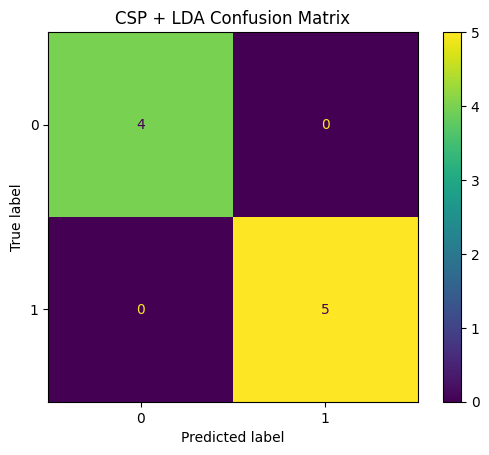

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# For CSP
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("CSP + LDA Confusion Matrix")
plt.savefig("../results/figures/confusion_matrix_csp.png", dpi=300, bbox_inches="tight")
plt.show()

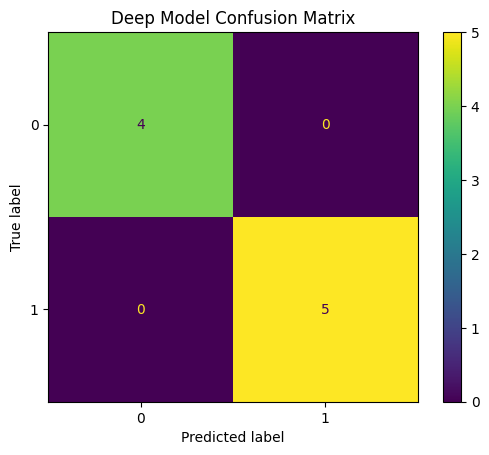

In [57]:
deep_preds = []

model.eval()
with torch.no_grad():
    for X_batch, _ in test_loader:
        out = model(X_batch)
        _, preds = torch.max(out, 1)
        deep_preds.extend(preds.cpu().numpy())

disp = ConfusionMatrixDisplay.from_predictions(y_test, deep_preds)
plt.title("Deep Model Confusion Matrix")
plt.savefig("../results/figures/confusion_matrix_dl.png", dpi=300, bbox_inches="tight")
plt.show()

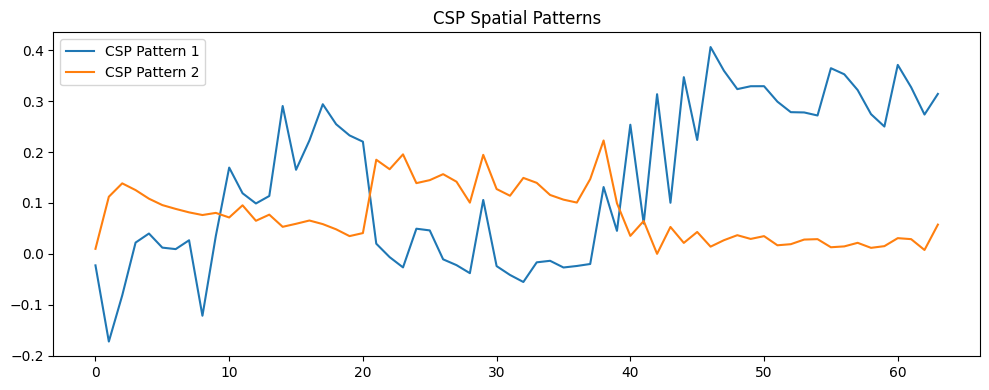

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.plot(csp_patterns[0], label="CSP Pattern 1")
plt.plot(csp_patterns[1], label="CSP Pattern 2")

plt.legend()
plt.title("CSP Spatial Patterns")
plt.tight_layout()

plt.savefig("../results/figures/csp_patterns.png", dpi=300, bbox_inches="tight")

plt.show()


In [35]:
import time
x = torch.tensor(X_test[0:1], dtype=torch.float32)

t0 = time.time()
out = model(x)
t1 = time.time()

print("Inference time (ms):", (t1 - t0) * 1000)

Inference time (ms): 91.06850624084473


In [ ]:
import json

metrics = {
    "CSP_LDA_accuracy": float(acc),
    "DeepModel_accuracy": float(acc_dl)
}

with open("../results/metrics/results.json", "w") as f:
    json.dump(metrics, f, indent=4)